# Detecting Pneumonia using Convolutional Neural Network (CNN)

## Import The Required Libraries

In [1]:
# basics
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

import pickle 

# Keras Libraries
import keras
import tensorflow as tf
from keras import backend as K
from keras import metrics
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, InputLayer, Activation
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.metrics import AUC
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import keras.backend


In [2]:
# Set a seed value
seed_value= 42

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(seed_value)

# 5. For layers that introduce randomness like dropout, make sure to set seed values 
#model.add(Dropout(0.25, seed=seed_value))

#6 Configure a new global `tensorflow` session
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

In [3]:
project_path = "E:\MIC_Projects\Pneumonia_Detection"
train_path = project_path + "/chest_xray/train/"
val_path = project_path + "/chest_xray/val/"
test_path = project_path + "/chest_xray/test/"

In [4]:
hyper_dimension = 64
hyper_batch_size = 128
hyper_epochs = 100

## Training in grayscale instead of RGB
hyper_channels = 1
hyper_mode = 'grayscale'

In [5]:
train_datagen = ImageDataGenerator(rescale=1.0/255.0, 
                                   shear_range = 0.2,
                                   zoom_range = 0.2, 
                                   horizontal_flip = True)
val_datagen = ImageDataGenerator(rescale=1.0/255.0) 
test_datagen = ImageDataGenerator(rescale=1.0/255.0) 


train_generator = train_datagen.flow_from_directory(directory = train_path, 
                                                    target_size = (hyper_dimension, hyper_dimension),
                                                    batch_size = hyper_batch_size, 
                                                    color_mode = hyper_mode,
                                                    class_mode = 'binary', 
                                                    seed = 42)
val_generator = val_datagen.flow_from_directory(directory = val_path, 
                                                 target_size = (hyper_dimension, hyper_dimension),
                                                 batch_size = hyper_batch_size, 
                                                 class_mode = 'binary',
                                                 color_mode = hyper_mode,
                                                 shuffle=False,
                                                 seed = 42)
test_generator = test_datagen.flow_from_directory(directory = test_path, 
                                                 target_size = (hyper_dimension, hyper_dimension),
                                                 batch_size = hyper_batch_size, 
                                                 class_mode = 'binary',
                                                 color_mode = hyper_mode,
                                                 shuffle=False,
                                                 seed = 42)

test_generator.reset()

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Top 3 Models

We first created a function to create two charts that shows the progress of training the neural network.

In [6]:
def create_charts(cnn, cnn_model):
    ## Define train & validation loss
    train_loss = cnn_model.history['loss']
    val_loss = cnn_model.history['val_loss']
    
    ## Define train & validation AUC
    train_auc_name = list(cnn_model.history.keys())[3]
    val_auc_name = list(cnn_model.history.keys())[1]
    train_auc = cnn_model.history[train_auc_name]
    val_auc = cnn_model.history[val_auc_name]
    
    ## Define y_pred & y_true
    y_true = test_generator.classes
    Y_pred = cnn.predict_generator(test_generator, steps = len(test_generator))
    y_pred = (Y_pred > 0.5).T[0]
    y_pred_prob = Y_pred.T[0]
    
    ## PLOT ##
    fig = plt.figure(figsize=(13, 10))
    
    ## PLOT 1: TRAIN VS. VALIDATION LOSS 
    plt.subplot(2,2,1)
    plt.title("Training vs. Validation Loss")
    plt.plot(train_loss, label='training loss')
    plt.plot(val_loss, label='validation loss')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()

    ## PLOT 2: TRAIN VS. VALIDATION AUC
    plt.subplot(2,2,2)
    plt.title("Training vs. Validation AUC Score")
    plt.plot(train_auc, label='training auc')
    plt.plot(val_auc, label='validation auc')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()
    
    ## PLOT 3: CONFUSION MATRIX
    plt.subplot(2,2,3)
      # Set up the labels for in the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    names = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
    counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ticklabels = ['Normal', 'Pneumonia']

      # Create confusion matrix as heatmap
    sns.set(font_scale = 1.4)
    ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Oranges', xticklabels=ticklabels, yticklabels=ticklabels )
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.title("Confusion Matrix") #plt.title("Confusion Matrix\n", fontsize=10)
    plt.xlabel("Predicted", size=14)
    plt.ylabel("Actual", size=14) 
    #plt.savefig('cm.png', transparent=True) 
    
    ## PLOT 4: ROC CURVE
    plt.subplot(2,2,4)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    auc = roc_auc_score(y_true, y_pred_prob)
    plt.title('ROC Curve')
    plt.plot([0, 1], [0, 1], 'k--', label = "Random (AUC = 50%)")
    plt.plot(fpr, tpr, label='CNN (AUC = {:.2f}%)'.format(auc*100))
    plt.xlabel('False Positive Rate', size=14)
    plt.ylabel('True Positive Rate', size=14)
    plt.legend(loc='best')
    #plt.savefig('roc.png', bbox_inches='tight', pad_inches=1)
    
    ## END PLOTS
    plt.tight_layout()
    ;
    
    ## Summary Statistics
    TN, FP, FN, TP = cm.ravel() # cm[0,0], cm[0, 1], cm[1, 0], cm[1, 1]
    accuracy = (TP + TN) / np.sum(cm) # % positive out of all predicted positives
    precision = TP / (TP+FP) # % positive out of all predicted positives
    recall =  TP / (TP+FN) # % positive out of all supposed to be positives
    specificity = TN / (TN+FP) # % negative out of all supposed to be negatives
    f1 = 2*precision*recall / (precision + recall)
    stats_summary = '[Summary Statistics]\nAccuracy = {:.2%} | Precision = {:.2%} | Recall = {:.2%} | Specificity = {:.2%} | F1 Score = {:.2%}'.format(accuracy, precision, recall, specificity, f1)
    print(stats_summary)

### Model #1: Conv2D x 3 + 64 dense units

In [7]:
cnn = Sequential()
cnn.add(InputLayer(input_shape=(hyper_dimension, hyper_dimension, hyper_channels)))
                                
cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Flatten())

cnn.add(Dense(activation='relu', units=64))
cnn.add(Dense(activation='sigmoid', units=1))

cnn.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=[AUC()])
cnn_model = cnn.fit_generator(train_generator, 
                              steps_per_epoch = len(train_generator), 
                              epochs = 100, 
                              validation_data = val_generator,
                              validation_steps = len(val_generator), 
                              verbose=1)


c:\python38\lib\site-packages\keras\engine\training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
41/41 [==============================] - 495s 11s/step - loss: 0.5987 - auc: 0.4823 - val_loss: 0.7681 - val_auc: 0.5391
Epoch 2/100
41/41 [==============================] - 76s 2s/step - loss: 0.5238 - auc: 0.7314 - val_loss: 0.7350 - val_auc: 0.7656
Epoch 3/100
41/41 [==============================] - 75s 2s/step - loss: 0.3460 - auc: 0.9131 - val_loss: 0.5914 - val_auc: 0.8828
Epoch 4/100
41/41 [==============================] - 76s 2s/step - loss: 0.2885 - auc: 0.9331 - val_loss: 0.5072 - val_auc: 0.8984
Epoch 5/100
41/41 [==============================] - 75s 2s/step - loss: 0.2210 - auc: 0.9604 - val_loss: 0.5084 - val_auc: 0.8438
Epoch 6/100
41/41 [==============================] - 76s 2s/step - loss: 0.2177 - auc: 0.9623 - val_loss: 0.5058 - val_auc: 0.8359
Epoch 7/100
41/41 [==============================] - 76s 2s/step - loss: 0.2082 - auc: 0.9653 - val_loss: 0.4551 - val_auc: 0.8516
Epoch 8/100
41/41 [==============================] - 82s 2s/step - loss: 0.1990 -

c:\python38\lib\site-packages\keras\engine\training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[Summary Statistics]
Accuracy = 90.38% | Precision = 87.50% | Recall = 98.72% | Specificity = 76.50% | F1 Score = 92.77%


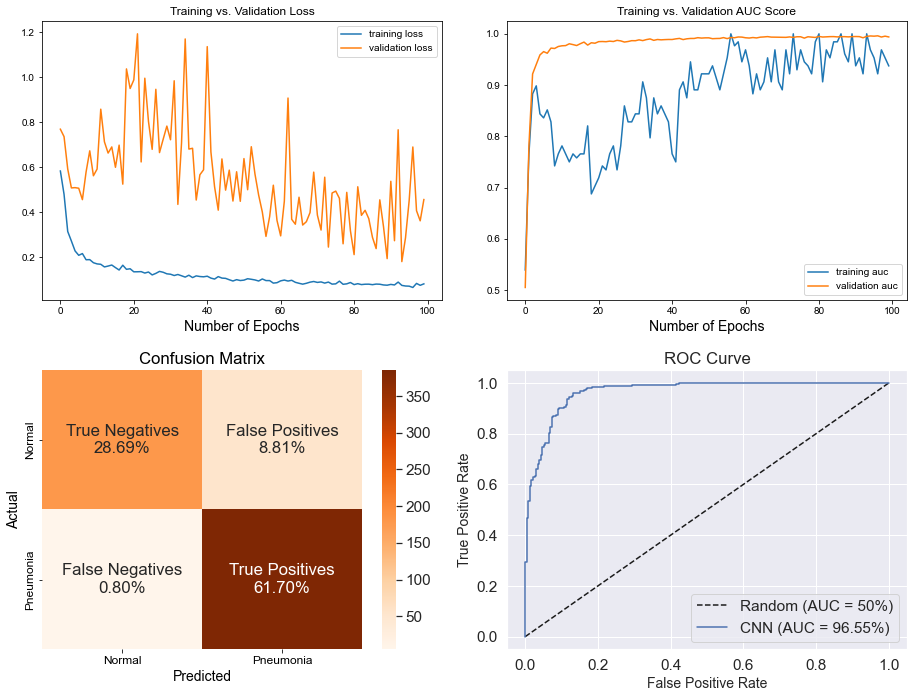

In [8]:
create_charts(cnn, cnn_model)

### Model #2: Conv2D x 4 + 64 dense units

In [ ]:
cnn = Sequential()
cnn.add(InputLayer(input_shape=(hyper_dimension, hyper_dimension, hyper_channels)))

cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Flatten())

cnn.add(Dense(activation='relu', units=64))
cnn.add(Dense(activation='sigmoid', units=1))

cnn.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=[AUC()])
cnn_model = cnn.fit_generator(train_generator, 
                              steps_per_epoch = len(train_generator), 
                              epochs = 100, 
                              validation_data = val_generator,
                              validation_steps = len(val_generator))

c:\python38\lib\site-packages\keras\engine\training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
41/41 [==============================] - 54s 1s/step - loss: 0.6280 - auc_1: 0.4972 - val_loss: 0.7799 - val_auc_1: 0.3672
Epoch 2/100
41/41 [==============================] - 48s 1s/step - loss: 0.5689 - auc_1: 0.5638 - val_loss: 0.8150 - val_auc_1: 0.6016
Epoch 3/100
20/41 [=============>................] - ETA: 23s - loss: 0.4896 - auc_1: 0.7868

In [ ]:
create_charts(cnn, cnn_model)

### Model #3: Conv2D x 2 + 64 dense units

In [ ]:
cnn = Sequential()
cnn.add(InputLayer(input_shape=(hyper_dimension, hyper_dimension, hyper_channels)))

cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Flatten())

cnn.add(Dense(activation='relu', units=64))
cnn.add(Dense(activation='sigmoid', units=1))

cnn.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=[AUC()])
cnn_model = cnn.fit_generator(train_generator, 
                              steps_per_epoch = len(train_generator), 
                              epochs = 100, 
                              validation_data = val_generator,
                              validation_steps = len(val_generator), 
                              verbose=2)

In [ ]:
create_charts(cnn, cnn_model)

### Model #4 (I): Conv2D x 3 + 128 dense units (100 epochs)

In [ ]:
# Conv2D x 3 + 128 dense units
cnn = Sequential()
cnn.add(InputLayer(input_shape=(hyper_dimension, hyper_dimension, hyper_channels)))

cnn.add(Conv2D(filters=hyper_feature_maps, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=hyper_feature_maps, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=hyper_feature_maps, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Flatten())

cnn.add(Dense(activation='relu', units=128))
cnn.add(Dense(activation='sigmoid', units=1))

cnn.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=[AUC()])
cnn_model = cnn.fit_generator(train_generator, 
                              steps_per_epoch = len(train_generator), 
                              epochs = 100, 
                              validation_data = val_generator,
                              validation_steps = len(val_generator), 
                              verbose=2)

In [ ]:
create_charts(cnn, cnn_model)

### Model #4 (II): Conv2D x 3 + 128 dense units (200 epochs)

In [ ]:
cnn = Sequential()
cnn.add(InputLayer(input_shape=(hyper_dimension, hyper_dimension, hyper_channels)))

cnn.add(Conv2D(filters=hyper_feature_maps, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=hyper_feature_maps, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=hyper_feature_maps, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Flatten())

cnn.add(Dense(activation='relu', units=128))
cnn.add(Dense(activation='sigmoid', units=1))

cnn.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=[AUC()])
cnn_model = cnn.fit_generator(train_generator, 
                              steps_per_epoch = len(train_generator), 
                              epochs = 200, 
                              validation_data = val_generator,
                              validation_steps = len(val_generator), 
                              verbose=2)

In [ ]:
create_charts(cnn, cnn_model)

### Model #5

In [ ]:
## batch size: 64 Conv2D (filter: 32, 64, 128)  x 3 + different dense units + Batch Normalization
cnn = Sequential()
cnn.add(InputLayer(input_shape=(hyper_dimension, hyper_dimension, hyper_channels)))

cnn.add(Conv2D(filters=32, kernel_size=3))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=64, kernel_size=3))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=128, kernel_size=3))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Flatten())

cnn.add(BatchNormalization())
cnn.add(Dense(activation='relu', units=1024))
cnn.add(Dense(activation='relu', units=512))
cnn.add(Dense(activation='sigmoid', units=1))

cnn.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=[AUC()])
cnn_model = cnn.fit_generator(train_generator, 
                              steps_per_epoch = len(train_generator), 
                              epochs = 100, 
                              validation_data = val_generator,
                              validation_steps = len(val_generator), 
                              verbose=2)

In [ ]:
create_charts(cnn, cnn_model)

### Model #6

In [ ]:
## Conv2D (filter: 32, 64, 128)  x 3 + different dense units + Batch Normalization + Dropout Dense layer
cnn = Sequential()
cnn.add(InputLayer(input_shape=(hyper_dimension, hyper_dimension, hyper_channels)))

cnn.add(Conv2D(filters=32, kernel_size=3, activation='elu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Activation('relu'))
cnn.add(Dropout(0.25))

cnn.add(Conv2D(filters=64, kernel_size=3, activation='elu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Activation('relu'))
cnn.add(Dropout(0.3))

cnn.add(Conv2D(filters=128, kernel_size=3, activation='elu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Activation('relu'))
cnn.add(Dropout(0.3))

cnn.add(Flatten())

cnn.add(BatchNormalization())
cnn.add(Dense(activation='relu', units=512))
cnn.add(Dropout(0.25))
cnn.add(Dense(activation='relu', units=256))
cnn.add(Dropout(0.25))
cnn.add(Dense(activation='sigmoid', units=1))

cnn.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=[AUC()])
cnn_model = cnn.fit_generator(train_generator, 
                              steps_per_epoch = len(train_generator), 
                              epochs = 100, 
                              validation_data = val_generator,
                              validation_steps = len(val_generator), 
                              verbose=2)

In [ ]:
create_charts(cnn, cnn_model)

## Conclusion

**Model #4 (200 epochs)** has the best result with the following architecture

    cnn = Sequential()
    cnn.add(InputLayer(input_shape=(hyper_dimension, hyper_dimension, hyper_channels)))

    cnn.add(Conv2D(filters=hyper_feature_maps, kernel_size=3, activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2,2)))

    cnn.add(Conv2D(filters=hyper_feature_maps, kernel_size=3, activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2,2)))

    cnn.add(Conv2D(filters=hyper_feature_maps, kernel_size=3, activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2,2)))

    cnn.add(Flatten())

    cnn.add(Dense(activation='relu', units=128))
    cnn.add(Dense(activation='sigmoid', units=1))

    cnn.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=[AUC()])
    cnn_model = cnn.fit_generator(train_generator, 
                                  steps_per_epoch = len(train_generator), 
                                  epochs = 200, 
                                  validation_data = val_generator,
                                  validation_steps = len(val_generator), 
                                  verbose=2)
                                  
                                  
 - AUC Score: 97.98%
 - Accuracy: 90.71%
 - Recall: 98.72% (FP = 8.49% and FN = 0.80%)
 
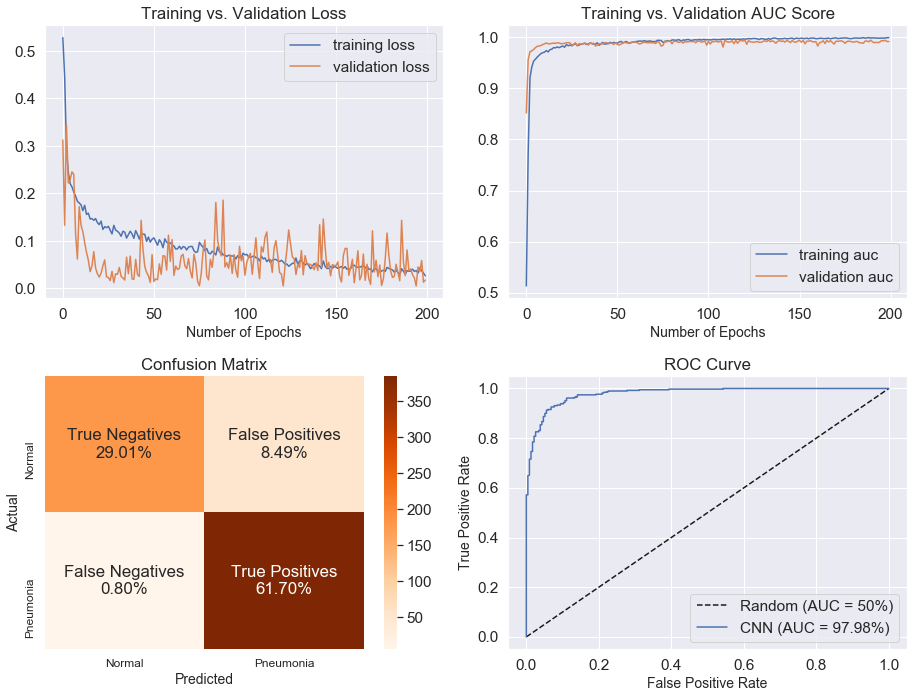